In [1]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from matplotlib import image
import numpy as np
from numpy import asarray
import os
import cv2
import scipy.optimize as opt

## Preparing Images - OPTIONAL

In [2]:
def convert_RGB(image):
    im_RGB = image.convert("RGB")
    return im_RGB

In [3]:
def resize(image):
    im_resize = image.resize((80,80), Image.ANTIALIAS)
    return im_resize

In [4]:
def process_image(path):
    for item in os.listdir(path):
        if os.path.isfile(path + item):
            im = Image.open(path + item)
            if im.mode != 'RGB':
                im = convert_RGB(im)
            im = resize(im)
            im.save(str(path+item), 'JPEG', quality=90)
            im.close()
        else:
            print("Path not found")                

In [5]:
# Run this if your image directories are not already processed
# process_image("CALIBRATION IMAGES/yoda/")
# process_image("CALIBRATION IMAGES/darthvader/")

## Defining Data

In [6]:
def create_x(path):
    X = []
    for item in os.listdir(path):
        if os.path.isfile(path + item):
            img = cv2.imread(path + item)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.array(np.ravel(img, order='F'))
            X.append(img)
    return np.array(X)

In [7]:
def create_y(X, label):
    y = np.array([label] * len(X), dtype="int16")
    return np.array(y)

In [8]:
darth_x = create_x("CALIBRATION IMAGES/darthvader/")
yoda_x = create_x("CALIBRATION IMAGES/yoda/")

In [9]:
darth_y = create_y(darth_x, [1,0])
yoda_y = create_y(yoda_x, [0,1])

In [10]:
print("Darth X Shape: ", darth_x.shape)
print("Darth y Shape: ", darth_y.shape)
print("Yoda X Shape: ", yoda_x.shape)
print("Yoda y Shape: ", yoda_y.shape)

Darth X Shape:  (409, 19200)
Darth y Shape:  (409, 2)
Yoda X Shape:  (381, 19200)
Yoda y Shape:  (381, 2)


In [11]:
X_all = np.vstack((darth_x, yoda_x))
y_all = np.vstack((darth_y, yoda_y))

In [12]:
data = np.hstack((X_all,y_all))

In [13]:
data.shape

(790, 19202)

## Data Visualization

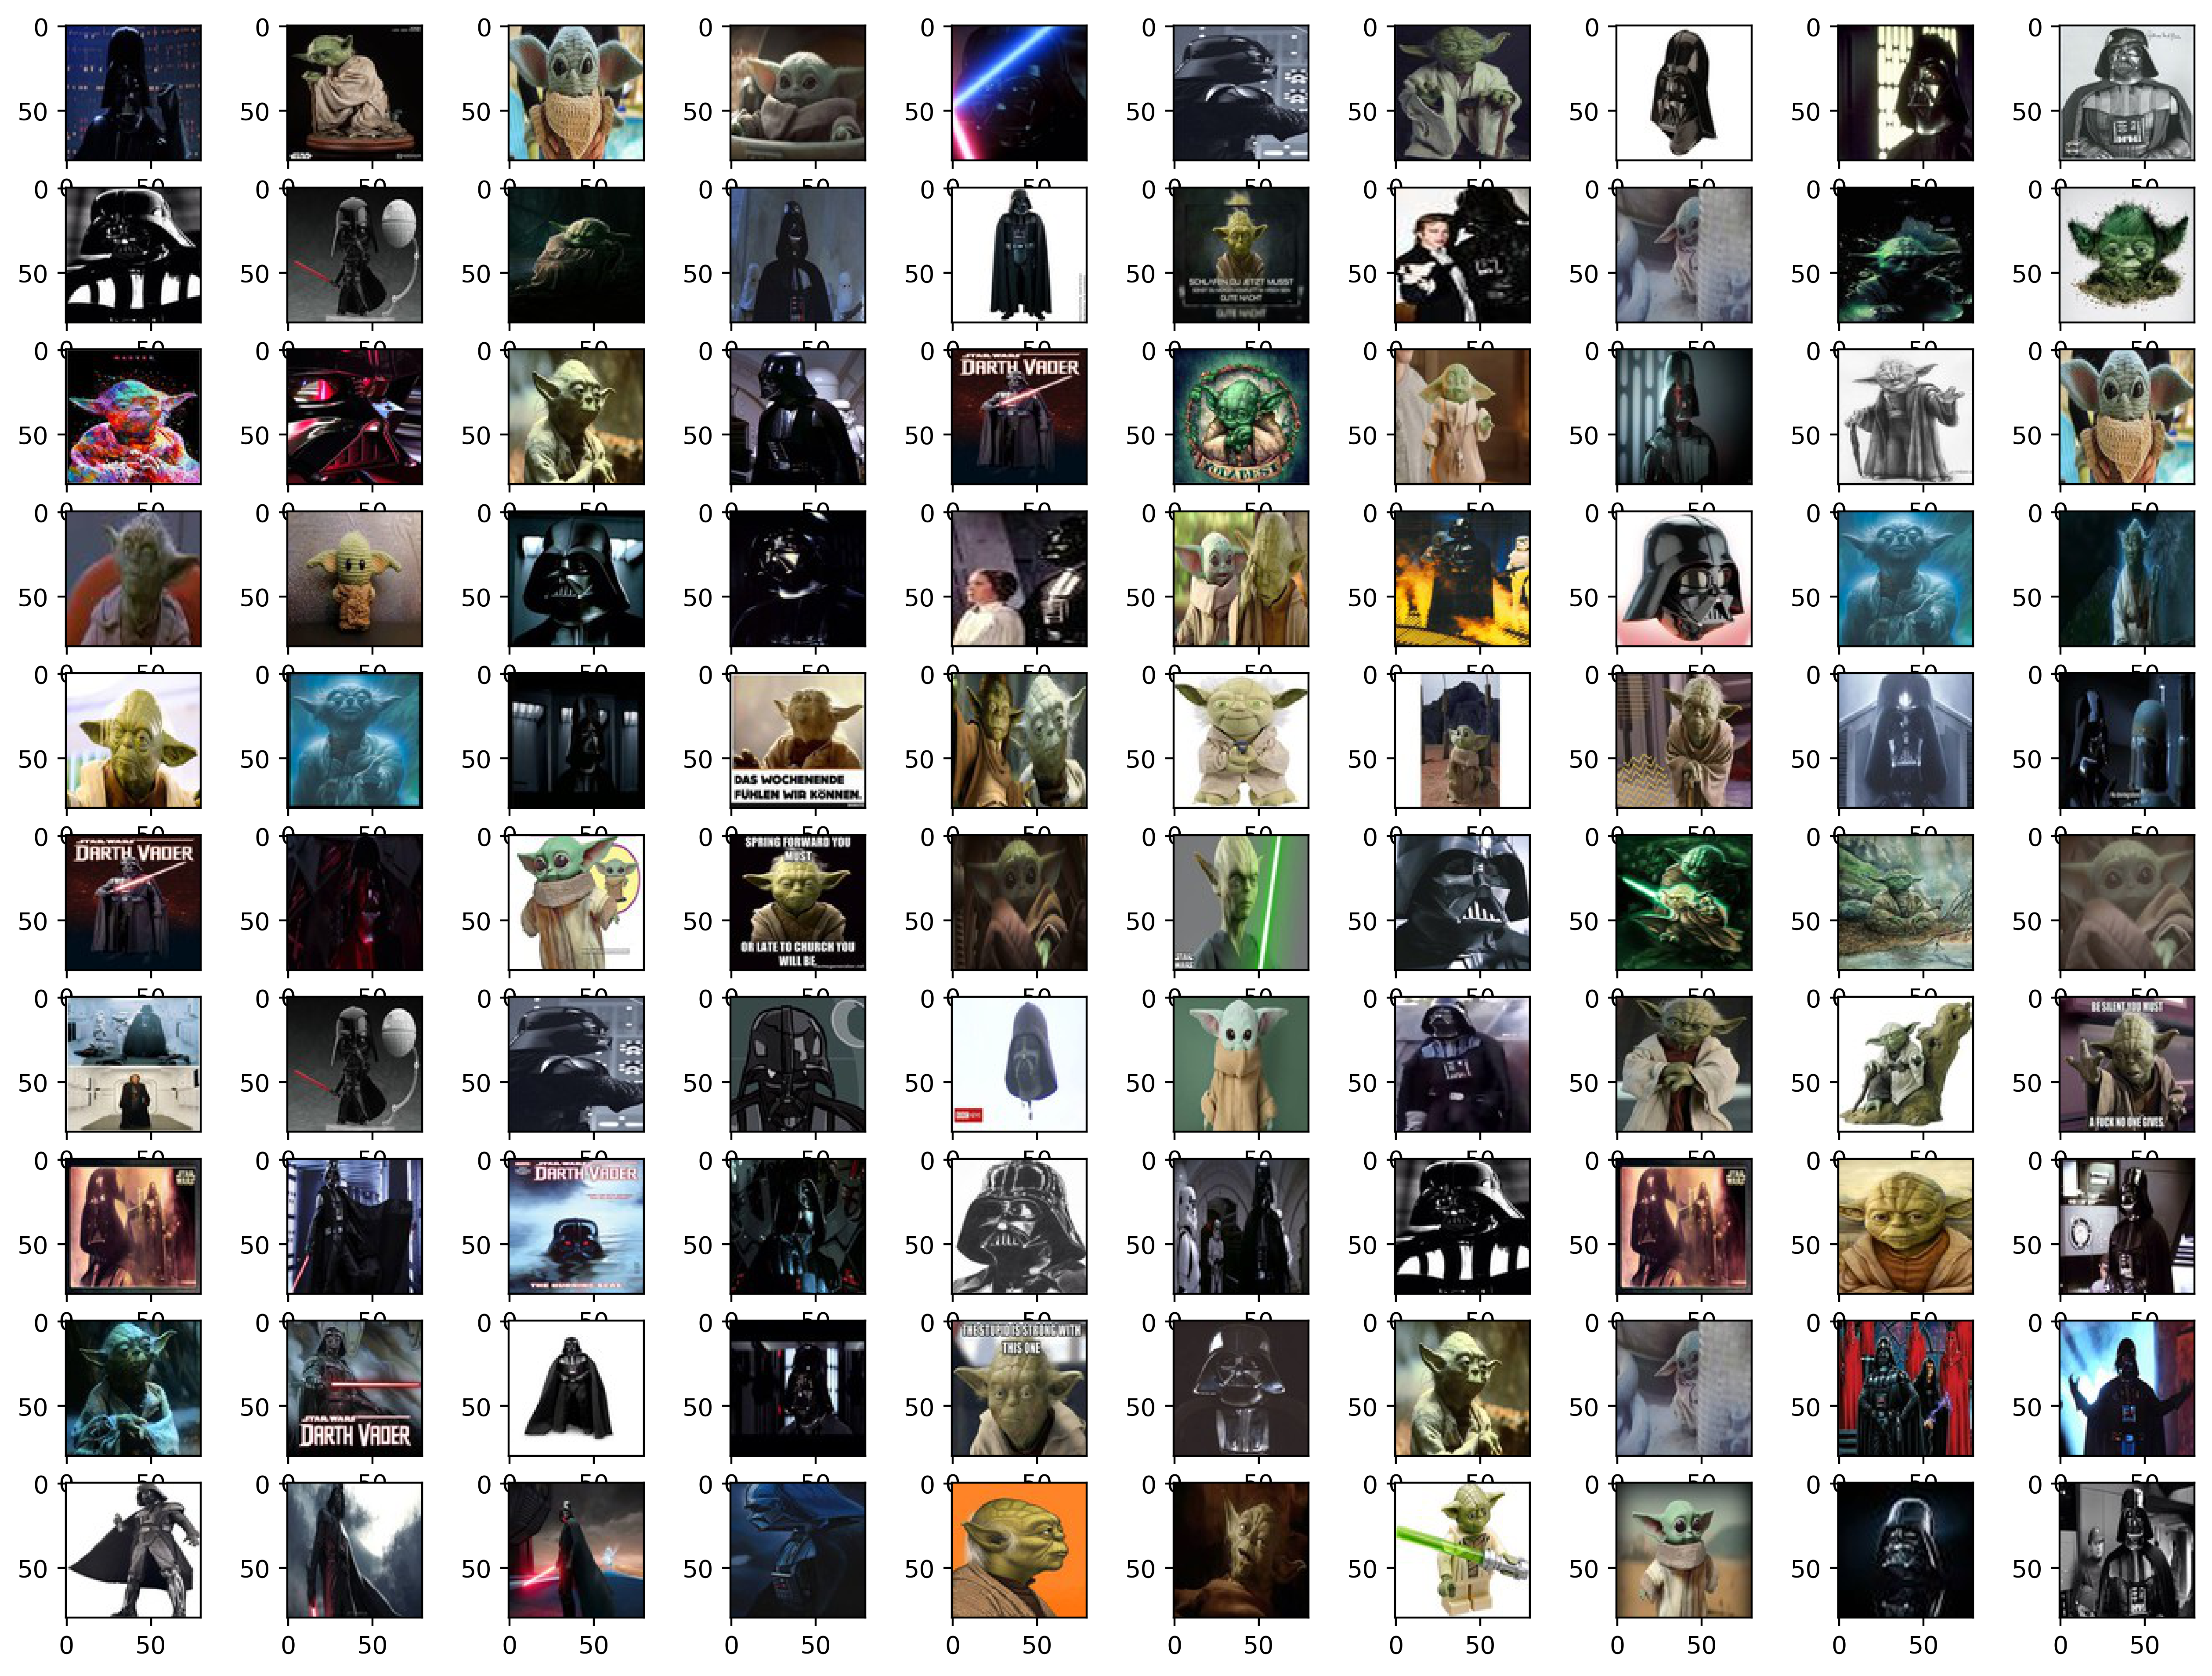

In [14]:
fig, ax = plt.subplots(10,10, figsize=(16, 12), dpi= 400, facecolor='w', edgecolor='k')
for row in range(10):
    for col in range(10):
        ax[row][col].imshow(X_all[np.random.randint(0, len(X_all)-1)].reshape((80,80,3), order='F'))

## Split Data

In [15]:
def train_test_split(X, y, test_ratio):
    m = len(X)
    split = int((m * test_ratio))

    X_train = X[:m-(split)]
    X_test = X[m-split:]
    y_train = y[:m-split]
    y_test = y[m-split:]
    
    print("X train shape: ", X_train.shape)
    print("y train shape: ", y_train.shape)
    print("X test shape: ", X_test.shape)
    print("y test shape: ", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [16]:
np.random.shuffle(data)

In [17]:
X_all = data[:, :-2]
y_all = data[:,-2:]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, .15)

X train shape:  (672, 19200)
y train shape:  (672, 2)
X test shape:  (118, 19200)
y test shape:  (118, 2)


## Parameters

In [19]:
m = len(X_train)
input_size = X_train.shape[1]
layer1_size = 64
layer2_size = 64
num_labels = y_train.shape[1]
lmda = 1

In [20]:
# The +1 is for the bias
theta1 = np.zeros((layer1_size, input_size+1))
theta2 = np.zeros((layer2_size, layer1_size+1))
theta3 = np.zeros((num_labels, layer2_size+1))

In [21]:
combined_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F'), theta3.ravel(order='F')))

In [22]:
print(theta1.ravel(order='F').shape)
print(theta2.ravel(order='F').shape)
print(theta3.ravel(order='F').shape)
print(combined_params.shape)

(1228864,)
(4160,)
(130,)
(1233154,)


## Feed-forward Cost Function

In [23]:
# Activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [24]:
def CostFunc(combined_params, input_size, layer1_size, layer2_size, num_labels, X, y, lmda):
    # Recovering theta1, theta2, theta3
    mark1 = (input_size+1)*layer1_size
    mark2 = mark1 + (layer1_size+1) * layer2_size
    
    theta1 = np.reshape(combined_params[:mark1], (layer1_size, input_size+1), order='F')
    theta2 = np.reshape(combined_params[mark1:mark2], (layer2_size, layer1_size+1), order='F')
    theta3 = np.reshape(combined_params[mark2:], (num_labels, layer2_size+1), order='F')
    
    m = len(y)
    
    # Feed-forward
    input_layer = np.hstack((np.ones(shape=(m,1)),X))
    input_layer_output = np.dot(input_layer, theta1.T)
    input_layer_sigmoid = sigmoid(input_layer_output)
    
    hlayer1 = np.hstack((np.ones(shape=(len(input_layer_sigmoid),1)),input_layer_sigmoid))
    hlayer1_output = np.dot(hlayer1, theta2.T)
    hlayer1_sigmoid = sigmoid(hlayer1_output)
    
    hlayer2 = np.hstack((np.ones(shape=(len(hlayer1_sigmoid),1)),hlayer1_sigmoid))
    hlayer2_output = np.dot(hlayer2, theta3.T)
    model_output = sigmoid(hlayer2_output)
    
    # Error Computation
    temporary1 = -y * np.log(model_output)
    temporary2 = (1-y) * np.log(1-model_output)
    error = temporary1-temporary2
    
    theta1_regularized = np.sum(np.sum(np.square(theta1[:,1:]), axis = 1))
    theta2_regularized = np.sum(np.sum(np.square(theta2[:,1:]), axis = 1))
    theta3_regularized = np.sum(np.sum(np.square(theta3[:,1:]), axis = 1))
    j_cost_unregularized = np.sum(np.sum(error)) * (1 / m)
    
    j_cost = j_cost_unregularized + (lmda / (2*m)) * (theta1_regularized + theta2_regularized + theta3_regularized)
    
    
    return j_cost  
    

## Gradient Backpropogation

In [25]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [26]:
def Gradient(nn_params, input_size, layer1_size, layer2_size, num_labels, X, y, lmda):    
    mark1 = (input_size+1)*layer1_size
    mark2 = mark1 + (layer1_size+1) * layer2_size
    
    initial_theta1 = np.reshape(nn_params[:mark1], (layer1_size, input_size+1), order='F')
    initial_theta2 = np.reshape(nn_params[mark1:mark2], (layer2_size, layer1_size+1), order='F')
    initial_theta3 = np.reshape(nn_params[mark2:], (num_labels, layer2_size+1), order='F')
    
    m = len(y)
    
    delta1 = np.zeros(shape=(initial_theta1.shape))
    delta2 = np.zeros(shape=(initial_theta2.shape))
    delta3 = np.zeros(shape=(initial_theta3.shape))
    
    for i in range(m):       
        
        # Feed-forward (same as cost function)
        ones = np.ones(1)
        input_layer = np.hstack((np.ones(1), X[i]))
        input_layer_output = np.dot(input_layer, initial_theta1.T)
        input_layer_sigmoid = sigmoid(input_layer_output)
        
        hlayer1 = np.hstack((np.ones(1), input_layer_sigmoid))
        hlayer1_output = np.dot(hlayer1, initial_theta2.T)
        hlayer1_sigmoid = sigmoid(hlayer1_output)
        
        hlayer2 = np.hstack((np.ones(1), hlayer1_sigmoid))
        hlayer2_output = np.dot(hlayer2, initial_theta3.T)
        model_output = sigmoid(hlayer2_output) 
        
        # Partial Derivatives (pd)
        pd4 = model_output - y[i,:][np.newaxis,:]
        
        hlayer1_output = np.hstack((ones, hlayer1_output))
        pd3 = np.dot(initial_theta3.T, pd4.T) * sigmoid_gradient(hlayer1_output).T[:, np.newaxis]
        
        input_layer_output = np.hstack((ones, input_layer_output))
        pd2 = np.dot(initial_theta2.T, pd3[1:,:]) * sigmoid_gradient(input_layer_output).T[:,np.newaxis]
        
        delta1 = delta1 + np.dot(pd2[1:,:], input_layer[np.newaxis,:])
        delta2 = delta2 + np.dot(pd3[1:,:], hlayer1[np.newaxis,:])
        delta3 = delta3 + np.dot(pd4.T, hlayer2[np.newaxis,:])
        
    # Average the gradients across the # of samples
    delta1 = delta1 / m
    delta2 = delta2 / m
    delta3 = delta3 / m
    
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmda / m
    delta3[:,1:] = delta3[:,1:] + initial_theta3[:,1:] * lmda / m
    
    return np.hstack((delta1.ravel(order = 'F'), delta2.ravel(order='F'), delta3.ravel(order='F')))

In [27]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer1_size, hidden_layer2_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = CostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer1_size, hidden_layer2_size, num_labels,myX,myy,mylambda)
        cost_low  = CostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer1_size, hidden_layer2_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))


## Compiling and Training

In [28]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

In [29]:
# Initialize Weights
initial_theta1 = randInitializeWeights(input_size, layer1_size)
initial_theta2 = randInitializeWeights(layer1_size, layer2_size)
initial_theta3 = randInitializeWeights(layer2_size, num_labels)

# unrolling parameters into a single column vector
initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F'), \
                               initial_theta3.ravel(order='F')))

In [30]:
theta_opt = opt.fmin_cg(maxiter = 50, f = CostFunc, x0 = initial_params, fprime = Gradient, \
                        args = (input_size, layer1_size, layer2_size, num_labels, X_train, y_train, lmda))

mark1 = (input_size+1)*layer1_size
mark2 = mark1 + (layer1_size+1) * layer2_size

theta1_opt = np.reshape(theta_opt[:mark1], (layer1_size, input_size+1), order='F')
theta2_opt = np.reshape(theta_opt[mark1:mark2], (layer2_size, layer1_size+1), order='F')
theta3_opt = np.reshape(theta_opt[mark2:], (num_labels, layer2_size+1), order='F')


<ipython-input-23-7df99c5c00bb>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


         Current function value: 4.128154
         Iterations: 50
         Function evaluations: 125
         Gradient evaluations: 125


## Predictions

In [31]:
def get_raw_predictions(X, theta1, theta2, theta3):
    m = len(X)
    
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    a3 = sigmoid(a2 @ theta2.T)
    a3 = np.hstack((ones, a3))
    raw_predictions = sigmoid(a3 @ theta3.T)
    
    return raw_predictions

In [32]:
raw_predictions = get_raw_predictions(X_test, theta1_opt, theta2_opt, theta3_opt)

<ipython-input-23-7df99c5c00bb>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [33]:
raw_predictions

array([[0.45662842, 0.54530771],
       [0.44286205, 0.55713609],
       [0.88110442, 0.12156695],
       [0.38273183, 0.61654368],
       [0.28766093, 0.71244329],
       [0.25150087, 0.74576189],
       [0.55371336, 0.44744344],
       [0.87335749, 0.1296066 ],
       [0.38273183, 0.61654368],
       [0.53861705, 0.46453687],
       [0.28766093, 0.71244329],
       [0.27598151, 0.7226315 ],
       [0.23519245, 0.76314522],
       [0.34596312, 0.65130404],
       [0.45662842, 0.54530771],
       [0.3218162 , 0.67576806],
       [0.63802591, 0.36548842],
       [0.27938732, 0.71729188],
       [0.23405239, 0.76240432],
       [0.26331677, 0.73295039],
       [0.28766093, 0.71244329],
       [0.72235598, 0.27989156],
       [0.83463521, 0.16701624],
       [0.34016123, 0.6591327 ],
       [0.89658733, 0.1056934 ],
       [0.28766093, 0.71244329],
       [0.88110442, 0.12156695],
       [0.45662842, 0.54530771],
       [0.28766093, 0.71244329],
       [0.44286205, 0.55713609],
       [0.

In [34]:
def get_indexed_predictions(raw_predictions):
    indexed_prediction = np.argmax(raw_predictions, axis=1)
    return indexed_prediction

In [35]:
def get_label_predictions(raw_predictions, m):
    indexed_predictions = get_indexed_predictions(raw_predictions)
    label_predictions = [None]*m
    
    for i in range(m):
        if indexed_predictions[i] == 0:
            label_predictions[i] = "Darth Vader"
        elif indexed_predictions[i] == 1:
            label_predictions[i] = "Yoda"
    
    return label_predictions
    

In [36]:
label_predictions = get_label_predictions(raw_predictions, len(X_test))

In [37]:
label_predictions

['Yoda',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Darth Vader',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Yoda',
 'Darth Vader',
 'Yoda',
 'Darth Vader',
 'Darth Vader',
 'Darth V

## Checking Predictions

In [38]:
def compare_predictions(raw_predictions, y_test):
    predictions = get_indexed_predictions(raw_predictions)
    answers = np.argmax(y_test, axis=1)
    
    return predictions == answers

In [39]:
compare_predictions(raw_predictions, y_test)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False])

## Visualizing Predictions

In [40]:
def display_predictions(x_test):
    rows = int(round(np.sqrt(len(x_test))) - 1)
    count = 0
    
    fig, ax = plt.subplots(rows, rows, figsize=(16, 12), dpi= 400, facecolor='w', edgecolor='k')


    
    for row in range(rows):
        for col in range(rows):
            ax[row][col].xaxis.set_visible(False)
            ax[row][col].yaxis.set_visible(False)
                               
            ax[row][col].text(40,-3, f"Predicted:{label_predictions[count]}", size=10, ha="center")
            ax[row][col].imshow(X_test[count].astype('uint8').reshape((80,80, 3), order='F'))
            count+=1

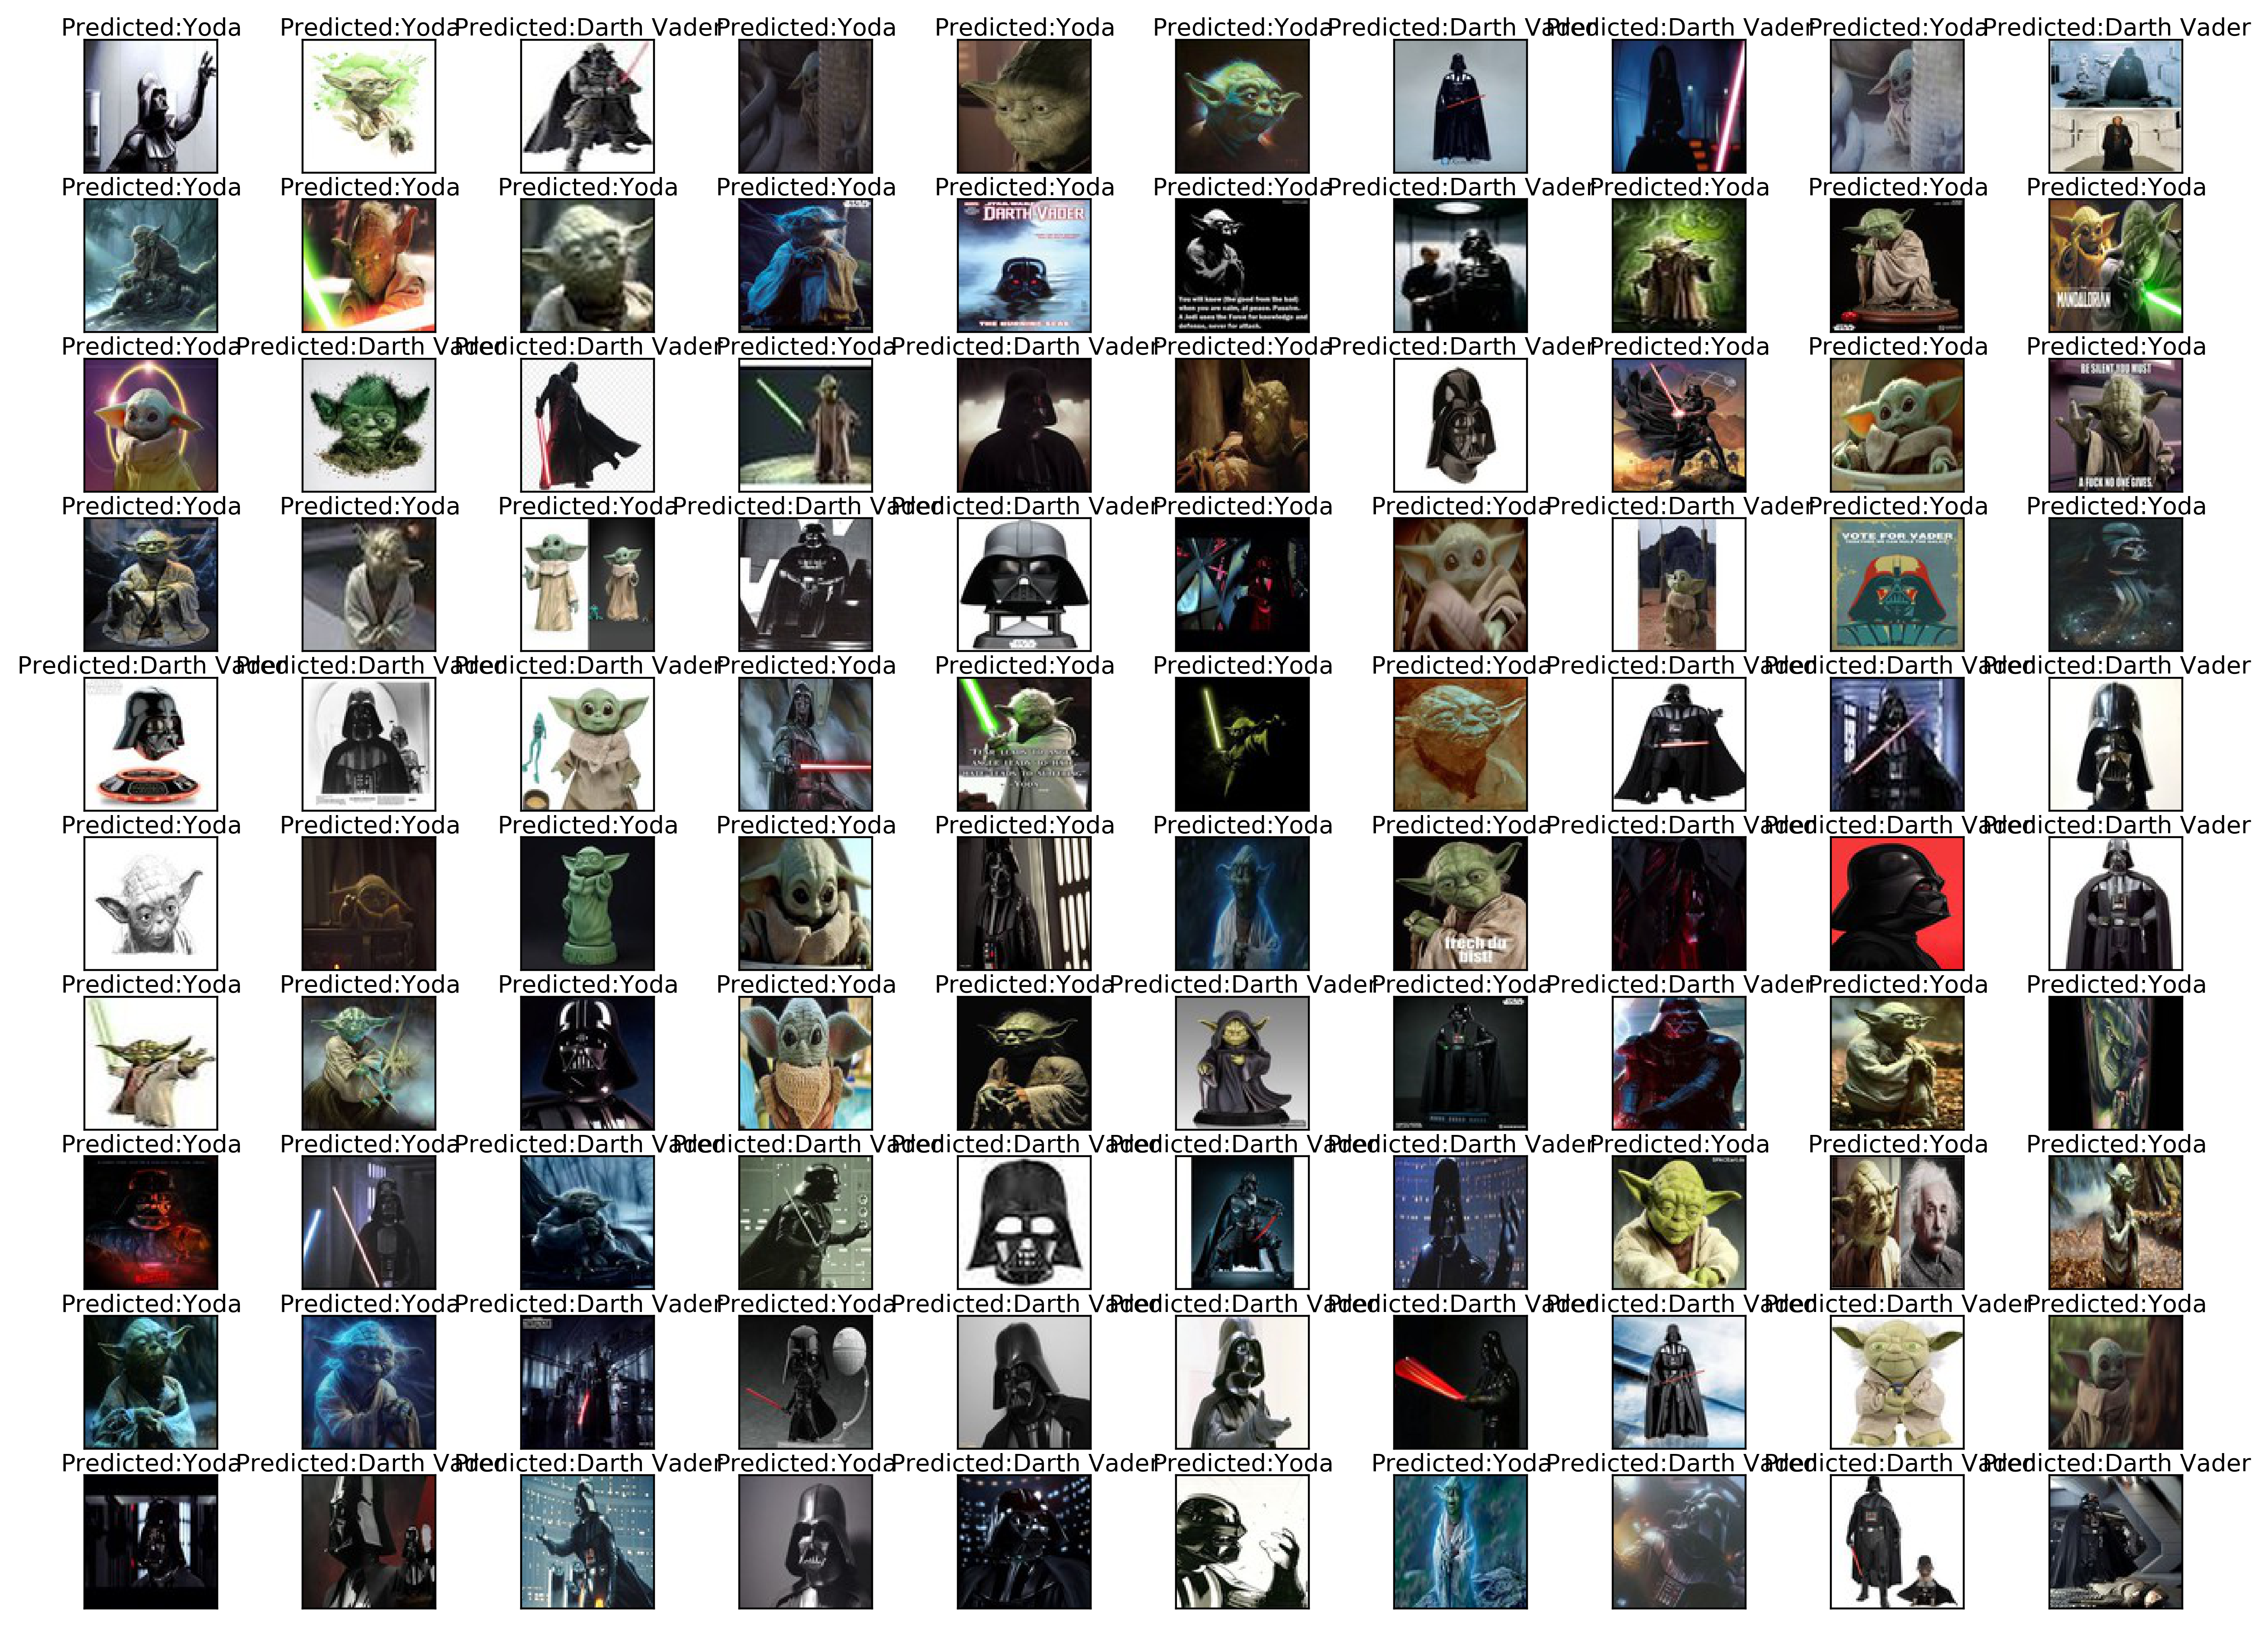

In [41]:
display_predictions(X_test)

## Accuracy

In [42]:
def get_model_accuracy(raw_predictions, y_test):
    accuracy = np.mean(np.argmax(raw_predictions, axis=1)==np.argmax(y_test, axis=1)) * 100
    return accuracy

In [43]:
print("Accuracy:", round(get_model_accuracy(raw_predictions, y_test),3), "%")

Accuracy: 75.424 %


## Confusion Matrix

In [44]:
def get_true_positives(indexed_predictions, raw_label, y_test):
    tp = 0
    for i in range(len(y_test)):
        if indexed_predictions[i] == raw_label == np.argmax(y_test[i]):
            tp += 1
    return tp

In [45]:
def get_false_positives(indexed_predictions, raw_label, y_test):
    fp = 0
    for i in range(len(y_test)):
        if indexed_predictions[i] == raw_label and indexed_predictions[i] != np.argmax(y_test[i]):
            fp += 1
    return fp

In [46]:
def get_true_negatives(indexed_predictions, raw_label, y_test):
    tn = 0
    for i in range(len(y_test)):
        if indexed_predictions[i] != raw_label and indexed_predictions[i] == np.argmax(y_test[i]):
            tn += 1
    return tn

In [47]:
def get_false_negatives(indexed_predictions, raw_label, y_test):
    fn = 0
    for i in range(len(y_test)):
        if indexed_predictions[i] != raw_label and indexed_predictions[i] != np.argmax(y_test[i]):
            fn += 1
    return fn

In [48]:
def get_confusion_matrix(indexed_predictions, raw_label, y_test):
    tp = get_true_positives(indexed_predictions, raw_label, y_test)
    fp = get_false_positives(indexed_predictions, raw_label, y_test)
    tn = get_true_negatives(indexed_predictions, raw_label, y_test)
    fn = get_false_negatives(indexed_predictions, raw_label, y_test)
    
    return tp, fp, tn, fn

In [49]:
vader_tp, vader_fp, vader_tn, vader_fn = get_confusion_matrix(get_indexed_predictions(raw_predictions), 0, y_test)
yoda_tp, yoda_fp, yoda_tn, yoda_fn = get_confusion_matrix(get_indexed_predictions(raw_predictions), 1, y_test)

In [50]:
print("CONFUSION MATRIX")
print("Vader true positive: ", vader_tp)
print("Vader false positive:", vader_fp)
print("Vader true negative: ", vader_tn)
print("Vader false negative:", vader_fn)
print()
print("Yoda true positive:  ", yoda_tp)
print("Yoda false positive: ", yoda_fp)
print("Yoda true negative:  ", yoda_tn)
print("Yoda false negative: ", yoda_fn)

CONFUSION MATRIX
Vader true positive:  36
Vader false positive: 7
Vader true negative:  53
Vader false negative: 22

Yoda true positive:   53
Yoda false positive:  22
Yoda true negative:   36
Yoda false negative:  7


## Precision, Recall

In [51]:
def get_precision_recall(tp, fp, fn):
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn) * 100

    return precision, recall

In [52]:
vader_precision, vader_recall = get_precision_recall(vader_tp, vader_fp, vader_fn)
yoda_precision, yoda_recall = get_precision_recall(yoda_tp, yoda_fp, yoda_fn)

In [53]:
print("PRECISION AND RECALL")
print("Vader Precision:", round(vader_precision, 3), "%")
print("Yoda Precision: ", round(yoda_precision, 3), "%")
print("Vader Recall:   ", round(vader_recall, 3), "%")
print("Yoda Recall:    ", round(yoda_recall, 3), "%")

PRECISION AND RECALL
Vader Precision: 83.721 %
Yoda Precision:  70.667 %
Vader Recall:    62.069 %
Yoda Recall:     88.333 %


In [54]:
average_precision = np.mean((vader_precision, yoda_precision))
average_recall = np.mean((vader_recall, yoda_recall))

In [55]:
print("Average Precision:", round(average_precision, 3), "%")
print("Average Recall:   ", round(average_recall, 3), "%")

Average Precision: 77.194 %
Average Recall:    75.201 %
